# Detección de Anomalías con LOF

## Pseudocódigo Formal del Algoritmo LOF

**ALGORITMO** `LocalOutlierFactor(D, k)`

**ENTRADA:**
- `D ← {x₁, x₂, …, xₙ}` (conjunto de datos con n objetos)
- `k` (número de vecinos más cercanos)

**SALIDA:**
- `LOF(xᵢ)` para cada `xᵢ ∈ D`

**PASOS:**

1. **Para cada punto** `xᵢ ∈ D`:
   - Calcular `dist_k(xᵢ)` ← distancia al k-ésimo vecino más cercano

2. **Para cada punto** `xᵢ ∈ D`:
   - `Nk(xᵢ)` ← conjunto de los k vecinos más cercanos de `xᵢ`

3. **Para cada punto** `xᵢ ∈ D`:
   - Calcular densidad local de alcanzabilidad:
   - `LRD(xᵢ) ← k / Σ reach_dist_k(xᵢ, xⱼ)` para cada `xⱼ ∈ Nk(xᵢ)`
   - Donde: `reach_dist_k(xᵢ, xⱼ) ← MAX { dist_k(xⱼ), distancia(xᵢ, xⱼ) }`

4. **Para cada punto** `xᵢ ∈ D`:
   - Calcular factor de atípico local:
   - `LOF(xᵢ) ← (1/k) * Σ (LRD(xⱼ) / LRD(xᵢ))` para cada `xⱼ ∈ Nk(xᵢ)`

5. **Retornar** `LOF(xᵢ)` para cada `xᵢ ∈ D`


In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmos de detección de anomalías
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Carga de datos - application_train
df_train = pd.read_csv("../../data/data/application_train.csv")

# Mostrar información básica
print("Shape de application_train:", df_train.shape)
print("\nPrimeras 5 filas:")
df_train.head()

Shape de application_train: (307511, 122)

Primeras 5 filas:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Paso 1: Seleccionar solo columnas numericas
columnas_numericas = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Excluir columna identificadora
if 'SK_ID_CURR' in columnas_numericas:
    columnas_numericas.remove('SK_ID_CURR')

# Crear dataframe solo con variables numericas
df_numerico = df_train[columnas_numericas].copy()

print("Total de columnas numericas:", len(columnas_numericas))
print("Dimensiones del dataframe numerico:", df_numerico.shape)

Total de columnas numericas: 105
Dimensiones del dataframe numerico: (307511, 105)


In [33]:
# Paso 2: Analizar valores nulos en el dataset
total_nulos = df_numerico.isnull().sum()
columnas_con_nulos = total_nulos[total_nulos > 0]

print("Total de columnas con valores nulos:", len(columnas_con_nulos))
print("\nPrimeras 10 columnas con mas valores nulos:")
print(columnas_con_nulos.sort_values(ascending=False).head(10))

Total de columnas con valores nulos: 61

Primeras 10 columnas con mas valores nulos:
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MODE       210199
FLOORSMIN_MEDI              208642
dtype: int64


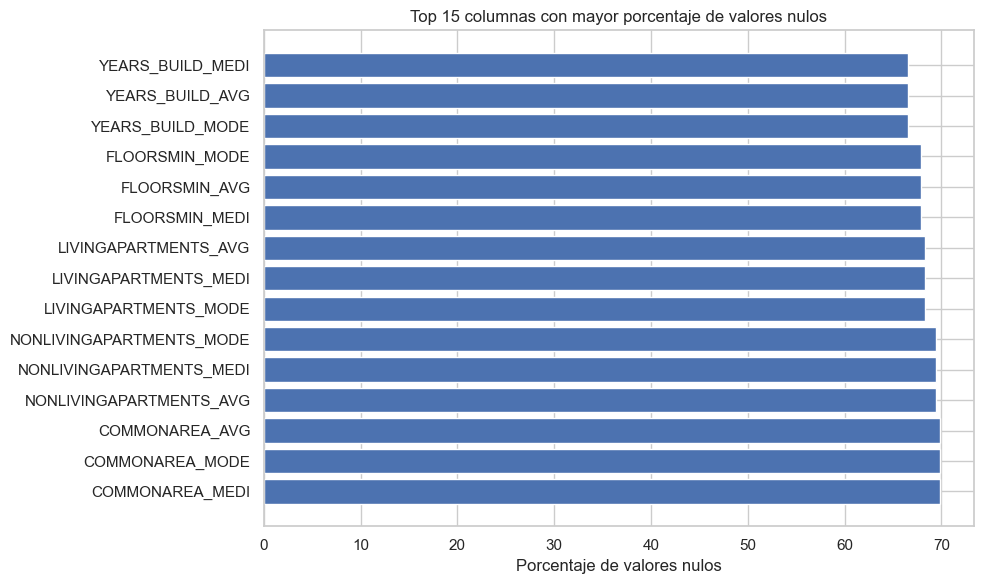

In [34]:
# Paso 3: Visualizar la distribucion de valores nulos
porcentaje_nulos = (df_numerico.isnull().sum() / len(df_numerico) * 100).sort_values(ascending=False)
top_nulos = porcentaje_nulos.head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_nulos)), top_nulos.values)
plt.yticks(range(len(top_nulos)), top_nulos.index)
plt.xlabel('Porcentaje de valores nulos')
plt.title('Top 15 columnas con mayor porcentaje de valores nulos')
plt.tight_layout()
plt.show()

In [36]:
# Paso 4: Tratamiento de valores nulos - Imputacion con la mediana
print("Aplicando imputacion con la mediana")
df_numerico_limpio = df_numerico.fillna(df_numerico.median())

print("Imputacion completada")

Aplicando imputacion con la mediana
Imputacion completada
Imputacion completada


In [38]:
# Paso 5: Verificar que no queden valores nulos
nulos_restantes = df_numerico_limpio.isnull().sum().sum()

print("Total de valores nulos despues de la imputacion:", nulos_restantes)
print("Dimensiones finales:", df_numerico_limpio.shape)

Total de valores nulos despues de la imputacion: 0
Dimensiones finales: (307511, 105)


In [41]:
# Paso 6: Deteccion de variables numericas para aplicar LOF
print("Variables numericas seleccionadas para LOF:")
print(f"Total: {len(columnas_numericas)} variables\n")

for i, col in enumerate(columnas_numericas, 1):
    print(f"{i}. {col}")

Variables numericas seleccionadas para LOF:
Total: 105 variables

1. TARGET
2. CNT_CHILDREN
3. AMT_INCOME_TOTAL
4. AMT_CREDIT
5. AMT_ANNUITY
6. AMT_GOODS_PRICE
7. REGION_POPULATION_RELATIVE
8. DAYS_BIRTH
9. DAYS_EMPLOYED
10. DAYS_REGISTRATION
11. DAYS_ID_PUBLISH
12. OWN_CAR_AGE
13. FLAG_MOBIL
14. FLAG_EMP_PHONE
15. FLAG_WORK_PHONE
16. FLAG_CONT_MOBILE
17. FLAG_PHONE
18. FLAG_EMAIL
19. CNT_FAM_MEMBERS
20. REGION_RATING_CLIENT
21. REGION_RATING_CLIENT_W_CITY
22. HOUR_APPR_PROCESS_START
23. REG_REGION_NOT_LIVE_REGION
24. REG_REGION_NOT_WORK_REGION
25. LIVE_REGION_NOT_WORK_REGION
26. REG_CITY_NOT_LIVE_CITY
27. REG_CITY_NOT_WORK_CITY
28. LIVE_CITY_NOT_WORK_CITY
29. EXT_SOURCE_1
30. EXT_SOURCE_2
31. EXT_SOURCE_3
32. APARTMENTS_AVG
33. BASEMENTAREA_AVG
34. YEARS_BEGINEXPLUATATION_AVG
35. YEARS_BUILD_AVG
36. COMMONAREA_AVG
37. ELEVATORS_AVG
38. ENTRANCES_AVG
39. FLOORSMAX_AVG
40. FLOORSMIN_AVG
41. LANDAREA_AVG
42. LIVINGAPARTMENTS_AVG
43. LIVINGAREA_AVG
44. NONLIVINGAPARTMENTS_AVG
45. NONLIVIN

In [44]:
# Paso 7: Preparar conjunto de datos final para LOF
# Tomar muestra del dataset
muestra_size = 10000
if len(df_numerico_limpio) > muestra_size:
    df_lof = df_numerico_limpio.sample(n=muestra_size, random_state=42)
    print(f"Muestra aleatoria de {muestra_size} registros creada")
else:
    df_lof = df_numerico_limpio.copy()
    print(f"Se usara el dataset completo ({len(df_lof)} registros)")

# Renombrar TODAS las variables a español para mejor interpretacion
nombres_espanol = {
    'TARGET': 'objetivo',
    'CNT_CHILDREN': 'num_hijos',
    'AMT_INCOME_TOTAL': 'ingreso_total',
    'AMT_CREDIT': 'monto_credito',
    'AMT_ANNUITY': 'anualidad',
    'AMT_GOODS_PRICE': 'precio_bienes',
    'REGION_POPULATION_RELATIVE': 'poblacion_region',
    'DAYS_BIRTH': 'edad_dias',
    'DAYS_EMPLOYED': 'dias_empleado',
    'DAYS_REGISTRATION': 'dias_registro',
    'DAYS_ID_PUBLISH': 'dias_publicacion_id',
    'OWN_CAR_AGE': 'edad_auto',
    'FLAG_MOBIL': 'tiene_movil',
    'FLAG_EMP_PHONE': 'tiene_telefono_trabajo',
    'FLAG_WORK_PHONE': 'tiene_telefono_casa',
    'FLAG_CONT_MOBILE': 'movil_alcanzable',
    'FLAG_PHONE': 'tiene_telefono',
    'FLAG_EMAIL': 'tiene_email',
    'CNT_FAM_MEMBERS': 'num_miembros_familia',
    'REGION_RATING_CLIENT': 'calificacion_region',
    'REGION_RATING_CLIENT_W_CITY': 'calificacion_region_ciudad',
    'HOUR_APPR_PROCESS_START': 'hora_solicitud',
    'REG_REGION_NOT_LIVE_REGION': 'region_diferente_residencia',
    'REG_REGION_NOT_WORK_REGION': 'region_diferente_trabajo',
    'LIVE_REGION_NOT_WORK_REGION': 'residencia_diferente_trabajo',
    'REG_CITY_NOT_LIVE_CITY': 'ciudad_diferente_residencia',
    'REG_CITY_NOT_WORK_CITY': 'ciudad_diferente_trabajo',
    'LIVE_CITY_NOT_WORK_CITY': 'ciudad_residencia_diferente_trabajo',
    'EXT_SOURCE_1': 'fuente_externa_1',
    'EXT_SOURCE_2': 'fuente_externa_2',
    'EXT_SOURCE_3': 'fuente_externa_3',
    'APARTMENTS_AVG': 'apartamentos_promedio',
    'BASEMENTAREA_AVG': 'area_sotano_promedio',
    'YEARS_BEGINEXPLUATATION_AVG': 'anos_inicio_explotacion_promedio',
    'YEARS_BUILD_AVG': 'anos_construccion_promedio',
    'COMMONAREA_AVG': 'area_comun_promedio',
    'ELEVATORS_AVG': 'elevadores_promedio',
    'ENTRANCES_AVG': 'entradas_promedio',
    'FLOORSMAX_AVG': 'pisos_max_promedio',
    'FLOORSMIN_AVG': 'pisos_min_promedio',
    'LANDAREA_AVG': 'area_terreno_promedio',
    'LIVINGAPARTMENTS_AVG': 'apartamentos_habitables_promedio',
    'LIVINGAREA_AVG': 'area_habitable_promedio',
    'NONLIVINGAPARTMENTS_AVG': 'apartamentos_no_habitables_promedio',
    'NONLIVINGAREA_AVG': 'area_no_habitable_promedio',
    'APARTMENTS_MODE': 'apartamentos_moda',
    'BASEMENTAREA_MODE': 'area_sotano_moda',
    'YEARS_BEGINEXPLUATATION_MODE': 'anos_inicio_explotacion_moda',
    'YEARS_BUILD_MODE': 'anos_construccion_moda',
    'COMMONAREA_MODE': 'area_comun_moda',
    'ELEVATORS_MODE': 'elevadores_moda',
    'ENTRANCES_MODE': 'entradas_moda',
    'FLOORSMAX_MODE': 'pisos_max_moda',
    'FLOORSMIN_MODE': 'pisos_min_moda',
    'LANDAREA_MODE': 'area_terreno_moda',
    'LIVINGAPARTMENTS_MODE': 'apartamentos_habitables_moda',
    'LIVINGAREA_MODE': 'area_habitable_moda',
    'NONLIVINGAPARTMENTS_MODE': 'apartamentos_no_habitables_moda',
    'NONLIVINGAREA_MODE': 'area_no_habitable_moda',
    'APARTMENTS_MEDI': 'apartamentos_mediana',
    'BASEMENTAREA_MEDI': 'area_sotano_mediana',
    'YEARS_BEGINEXPLUATATION_MEDI': 'anos_inicio_explotacion_mediana',
    'YEARS_BUILD_MEDI': 'anos_construccion_mediana',
    'COMMONAREA_MEDI': 'area_comun_mediana',
    'ELEVATORS_MEDI': 'elevadores_mediana',
    'ENTRANCES_MEDI': 'entradas_mediana',
    'FLOORSMAX_MEDI': 'pisos_max_mediana',
    'FLOORSMIN_MEDI': 'pisos_min_mediana',
    'LANDAREA_MEDI': 'area_terreno_mediana',
    'LIVINGAPARTMENTS_MEDI': 'apartamentos_habitables_mediana',
    'LIVINGAREA_MEDI': 'area_habitable_mediana',
    'NONLIVINGAPARTMENTS_MEDI': 'apartamentos_no_habitables_mediana',
    'NONLIVINGAREA_MEDI': 'area_no_habitable_mediana',
    'FONDKAPREMONT_MODE': 'fondo_reparaciones_moda',
    'HOUSETYPE_MODE': 'tipo_casa_moda',
    'TOTALAREA_MODE': 'area_total_moda',
    'WALLSMATERIAL_MODE': 'material_paredes_moda',
    'EMERGENCYSTATE_MODE': 'estado_emergencia_moda',
    'OBS_30_CNT_SOCIAL_CIRCLE': 'obs_30dias_circulo_social',
    'DEF_30_CNT_SOCIAL_CIRCLE': 'def_30dias_circulo_social',
    'OBS_60_CNT_SOCIAL_CIRCLE': 'obs_60dias_circulo_social',
    'DEF_60_CNT_SOCIAL_CIRCLE': 'def_60dias_circulo_social',
    'DAYS_LAST_PHONE_CHANGE': 'dias_ultimo_cambio_telefono',
    'FLAG_DOCUMENT_2': 'tiene_documento_2',
    'FLAG_DOCUMENT_3': 'tiene_documento_3',
    'FLAG_DOCUMENT_4': 'tiene_documento_4',
    'FLAG_DOCUMENT_5': 'tiene_documento_5',
    'FLAG_DOCUMENT_6': 'tiene_documento_6',
    'FLAG_DOCUMENT_7': 'tiene_documento_7',
    'FLAG_DOCUMENT_8': 'tiene_documento_8',
    'FLAG_DOCUMENT_9': 'tiene_documento_9',
    'FLAG_DOCUMENT_10': 'tiene_documento_10',
    'FLAG_DOCUMENT_11': 'tiene_documento_11',
    'FLAG_DOCUMENT_12': 'tiene_documento_12',
    'FLAG_DOCUMENT_13': 'tiene_documento_13',
    'FLAG_DOCUMENT_14': 'tiene_documento_14',
    'FLAG_DOCUMENT_15': 'tiene_documento_15',
    'FLAG_DOCUMENT_16': 'tiene_documento_16',
    'FLAG_DOCUMENT_17': 'tiene_documento_17',
    'FLAG_DOCUMENT_18': 'tiene_documento_18',
    'FLAG_DOCUMENT_19': 'tiene_documento_19',
    'FLAG_DOCUMENT_20': 'tiene_documento_20',
    'FLAG_DOCUMENT_21': 'tiene_documento_21',
    'AMT_REQ_CREDIT_BUREAU_HOUR': 'consultas_buro_ultima_hora',
    'AMT_REQ_CREDIT_BUREAU_DAY': 'consultas_buro_ultimo_dia',
    'AMT_REQ_CREDIT_BUREAU_WEEK': 'consultas_buro_ultima_semana',
    'AMT_REQ_CREDIT_BUREAU_MON': 'consultas_buro_ultimo_mes',
    'AMT_REQ_CREDIT_BUREAU_QRT': 'consultas_buro_ultimo_trimestre',
    'AMT_REQ_CREDIT_BUREAU_YEAR': 'consultas_buro_ultimo_ano'
}

# Aplicar renombrado solo a columnas que existen
columnas_renombrar = {k: v for k, v in nombres_espanol.items() if k in df_lof.columns}
df_lof = df_lof.rename(columns=columnas_renombrar)

print(f"\nVariables renombradas a español: {len(columnas_renombrar)} de {df_lof.shape[1]}")

Muestra aleatoria de 10000 registros creada

Variables renombradas a español: 105 de 105


In [45]:
# Paso 8: Definir parametros del algoritmo LOF
D = df_lof.copy()
k = 20

In [47]:
# Paso 9: Aplicar algoritmo LOF y detectar anomalias
modelo_lof = LocalOutlierFactor(n_neighbors=k, contamination='auto')
etiquetas = modelo_lof.fit_predict(D)

In [48]:
# Paso 10: Obtener scores LOF
scores_lof = -modelo_lof.negative_outlier_factor_

D['score_lof'] = scores_lof
D['etiqueta'] = etiquetas
D['es_anomalia'] = etiquetas == -1

In [49]:
# Paso 11: Analizar anomalias detectadas
total_anomalias = D['es_anomalia'].sum()
porcentaje = (total_anomalias / len(D)) * 100

print(f"Anomalias detectadas: {total_anomalias} ({porcentaje:.2f}%)")
print(f"Observaciones normales: {len(D) - total_anomalias}")

# Top 10 anomalias
top_10 = D[D['es_anomalia']].nlargest(10, 'score_lof')[['score_lof']]
print("\nTop 10 anomalias:")
print(top_10)

Anomalias detectadas: 486 (4.86%)
Observaciones normales: 9514

Top 10 anomalias:
         score_lof
12840   294.337652
11287     8.488258
155716    5.583187
248058    5.572482
240712    5.211012
206327    4.369190
214789    4.284847
101508    4.229148
267302    3.971219
204453    3.918617


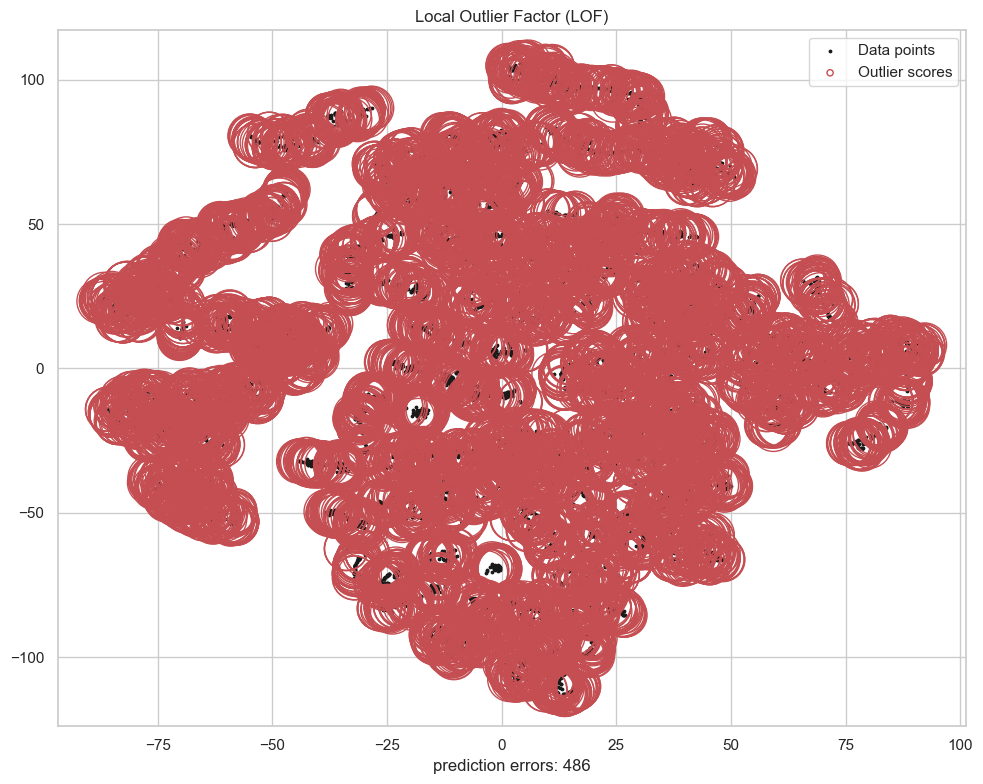

Grafico guardado en: results/lof_visualizacion.png


In [ ]:
# Paso 12: Visualizar Local Outlier Factor (LOF)
from sklearn.manifold import TSNE
from matplotlib.legend_handler import HandlerPathCollection

# Reducir dimensionalidad a 2D con t-SNE para visualizacion
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
datos_2d = tsne.fit_transform(D.drop(['score_lof', 'etiqueta', 'es_anomalia'], axis=1))

# Funcion para personalizar el tamaño del marcador en la leyenda
def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])

# Crear figura
plt.figure(figsize=(10, 8))

# Graficar los puntos de datos
plt.scatter(datos_2d[:, 0], datos_2d[:, 1], 
           color='k', 
           s=3.0, 
           label='Data points')

# Calcular radio proporcional a los outlier scores
X_scores = D['score_lof'].values
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

# Graficar circulos con radio proporcional a los outlier scores
scatter = plt.scatter(
    datos_2d[:, 0],
    datos_2d[:, 1],
    s=1000 * radius,
    edgecolors='r',
    facecolors='none',
    label='Outlier scores'
)

plt.axis('tight')
plt.xlabel(f'prediction errors: {sum(D["es_anomalia"])}')
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title('Local Outlier Factor (LOF)')

plt.tight_layout()
plt.show()

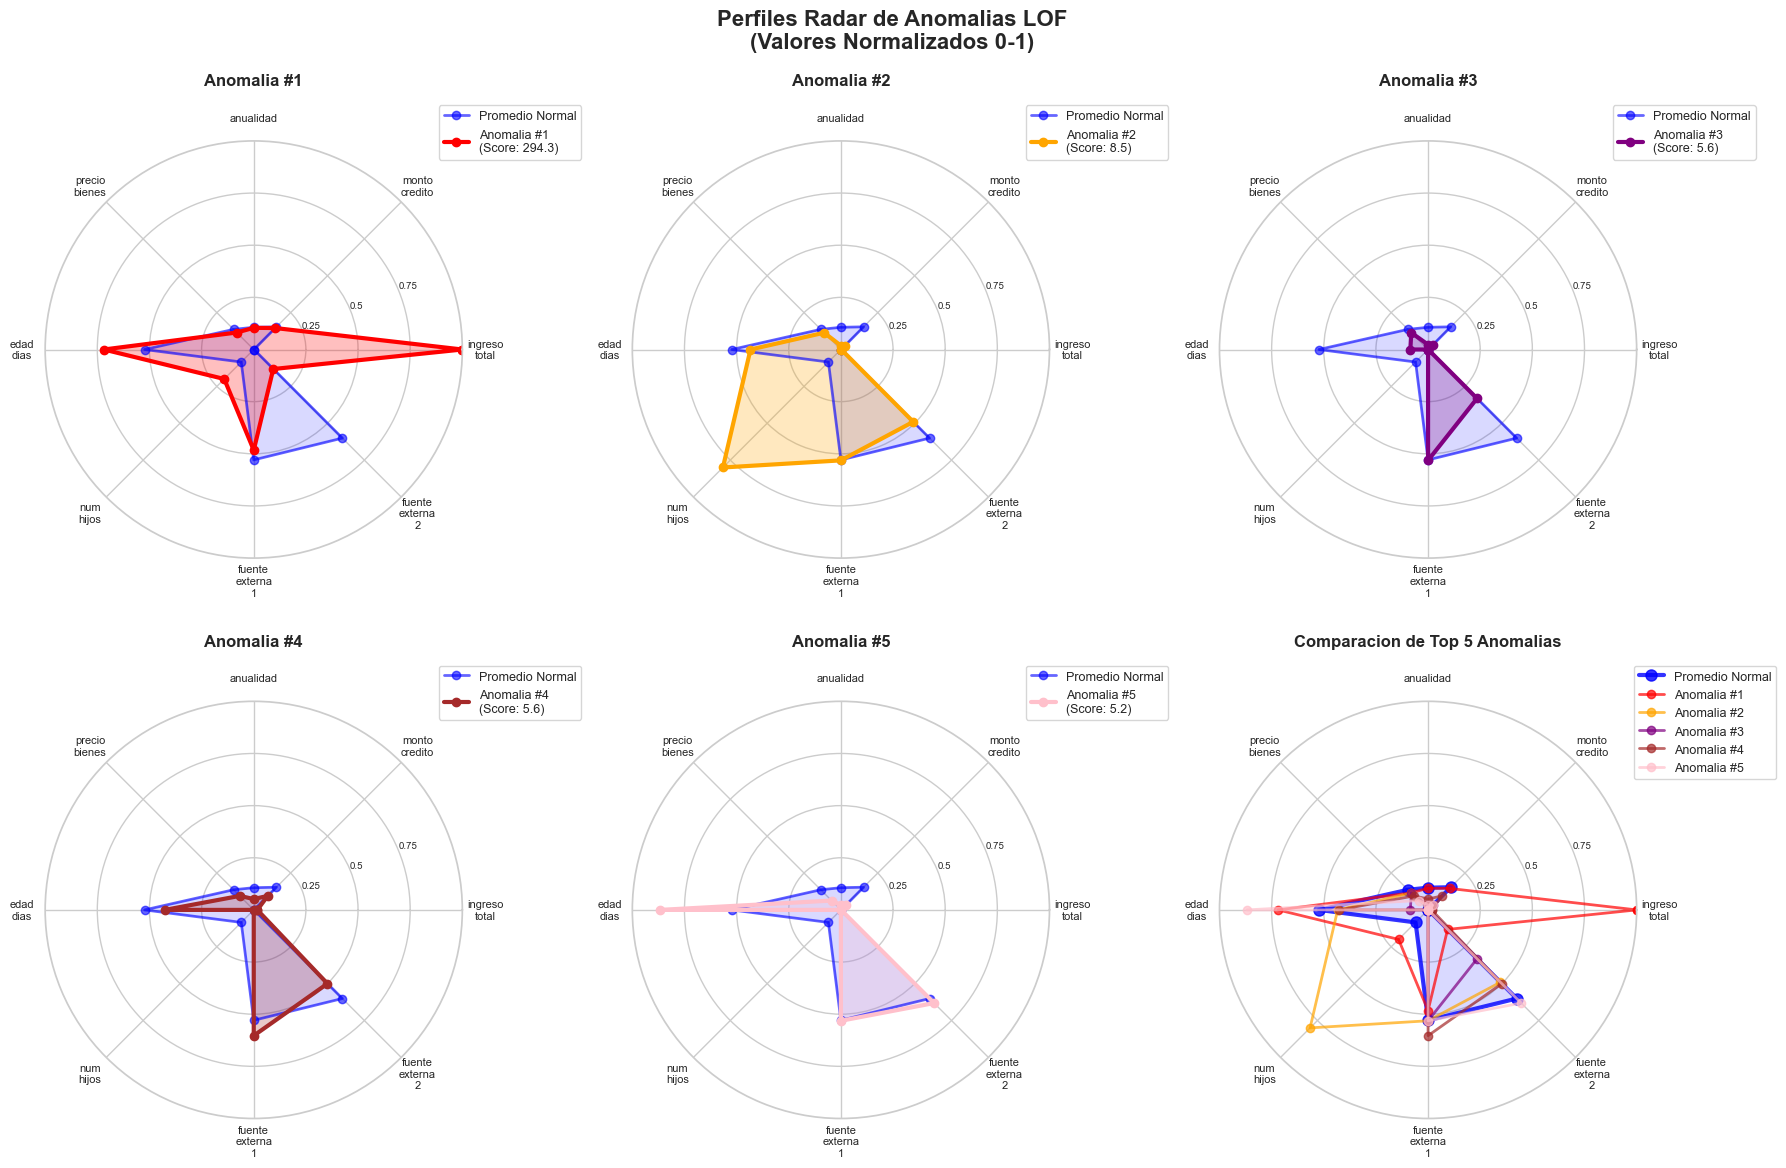

Grafico guardado en: results/lof_radar_anomalias.png


In [ ]:
# Paso 13: Grafico Radar de Anomalias - Comparacion visual de perfiles
from math import pi

# Seleccionar variables para el radar
vars_radar = ['ingreso_total', 'monto_credito', 'anualidad', 'precio_bienes', 
              'edad_dias', 'num_hijos', 'fuente_externa_1', 'fuente_externa_2']

# Normalizar datos entre 0 y 1 para mejor visualizacion
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Preparar datos
datos_radar = D[D.columns.difference(['score_lof', 'etiqueta', 'es_anomalia'])]
datos_normalizados = pd.DataFrame(
    scaler.fit_transform(datos_radar),
    columns=datos_radar.columns,
    index=datos_radar.index
)

# Seleccionar top 5 anomalias y promedio normal
top_5_anomalias = D[D['es_anomalia']].nlargest(5, 'score_lof').index
promedio_normal = datos_normalizados[~D['es_anomalia']][vars_radar].mean()

# Crear figura con 3x2 subplots para los radares
fig = plt.figure(figsize=(18, 12))

# Configuracion del radar
num_vars = len(vars_radar)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Colores para cada anomalia
colores_anomalias = ['red', 'orange', 'purple', 'brown', 'pink']

# Graficar cada anomalia en un subplot
for idx, (anomalia_idx, color) in enumerate(zip(top_5_anomalias, colores_anomalias), 1):
    ax = plt.subplot(2, 3, idx, projection='polar')
    
    # Datos de la anomalia
    valores_anomalia = datos_normalizados.loc[anomalia_idx, vars_radar].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    
    # Datos promedio normal
    valores_normal = promedio_normal.values.tolist()
    valores_normal += valores_normal[:1]
    
    # Graficar
    ax.plot(angles, valores_normal, 'o-', linewidth=2, label='Promedio Normal', color='blue', alpha=0.6)
    ax.fill(angles, valores_normal, alpha=0.15, color='blue')
    
    ax.plot(angles, valores_anomalia, 'o-', linewidth=3, 
            label=f'Anomalia #{idx}\n(Score: {D.loc[anomalia_idx, "score_lof"]:.1f})', 
            color=color)
    ax.fill(angles, valores_anomalia, alpha=0.25, color=color)
    
    # Configurar ejes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([v.replace('_', '\n') for v in vars_radar], size=8)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(['0.25', '0.5', '0.75'], size=7)
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.set_title(f'Anomalia #{idx}', size=12, fontweight='bold', pad=20)

# Subplot 6: Comparacion multiple de todas las top 5
ax = plt.subplot(2, 3, 6, projection='polar')

# Graficar promedio normal
valores_normal = promedio_normal.values.tolist()
valores_normal += valores_normal[:1]
ax.plot(angles, valores_normal, 'o-', linewidth=3, label='Promedio Normal', 
        color='blue', alpha=0.8, markersize=8)
ax.fill(angles, valores_normal, alpha=0.15, color='blue')

# Graficar todas las anomalias
for idx, (anomalia_idx, color) in enumerate(zip(top_5_anomalias, colores_anomalias), 1):
    valores_anomalia = datos_normalizados.loc[anomalia_idx, vars_radar].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    ax.plot(angles, valores_anomalia, 'o-', linewidth=2, 
            label=f'Anomalia #{idx}', color=color, alpha=0.7)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([v.replace('_', '\n') for v in vars_radar], size=8)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75])
ax.set_yticklabels(['0.25', '0.5', '0.75'], size=7)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=9)
ax.set_title('Comparacion de Top 5 Anomalias', size=12, fontweight='bold', pad=20)

plt.suptitle('Perfiles Radar de Anomalias LOF\n(Valores Normalizados 0-1)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()